# TP 4.  Test. Détection de Pulsars

<img src="http://media.giphy.com/media/gw3IWyGkC0rsazTi/giphy.gif"  width="300">

## Plan :

   [- 1. Statistiques descriptives](#1)
   
   [- 2. SVM](#2)
   
   [- 3. Naive Bayes, LDA, QDA](#3)
   
   [- 4. k-NN](#4)
   
   [- 5. Régression logisitique](#5)

Une description des données est disponible ici:
    https://archive.ics.uci.edu/ml/datasets/HTRU2#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import pandas as pd
import seaborn as sns

In [2]:
pulsars = pd.read_csv('HTRU_2.csv', header =None)
pulsars.columns = ['m1', 'sd1', 'kur1', 'skw1','m2', 'sd2', 'kur2', 'skw2', 'Class']
pulsars.head()

,m1,sd1,kur1,skw1,m2,sd2,kur2,skw2,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Les 9 variables présentes décrivent les caractéristiques suivantes :

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class 

Les  premières variables sont des variables explicatives continues et la variable Class est la variable binaire à expliquer codant pour la présence/absence d'un pulsar.

L'objectif de ce TP est d'utiliser les méthodes de machine learning vues en cours pour apprendre à reconnaître de manière autonome la présence d'un puslar.

<img src="http://media.giphy.com/media/ASd0Ukj0y3qMM/giphy.gif" width = 300>
<a id="1"></a> 
 
# 1. Statistiques descriptives


### Question 1

TAILLE DU DATASET

In [3]:
print("Le dataset pulsar possèdent n lignes et p colonnes avec : "+"n = {}, p = {}".format(pulsars.shape[0],pulsars.shape[1]))

Le dataset pulsar possèdent n lignes et p colonnes avec : n = 17898, p = 9


RESUME STATISTIQUE

In [5]:
pulsars.describe()

,m1,sd1,kur1,skw1,m2,sd2,kur2,skw2,Class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


BOXPLOTS

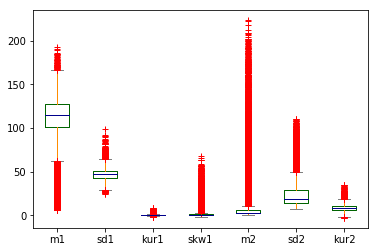

In [8]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
pulsars.iloc[:,0:7].plot.box(color=color, sym='r+');

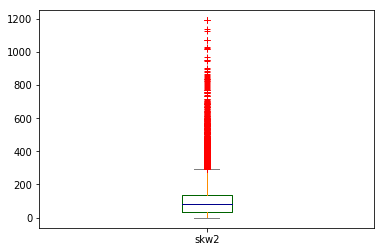

In [9]:
pulsars.iloc[:,7].plot.box(color=color, sym='r+');

** Commentaire ** : les boxplots présentent tous un grand nombre d'outliers ainsi qu'une asymétrie dans leur distribution. Il est très probable que ces distributions soient éloignées d'une distribution normale. 

HISTOGRAMMES

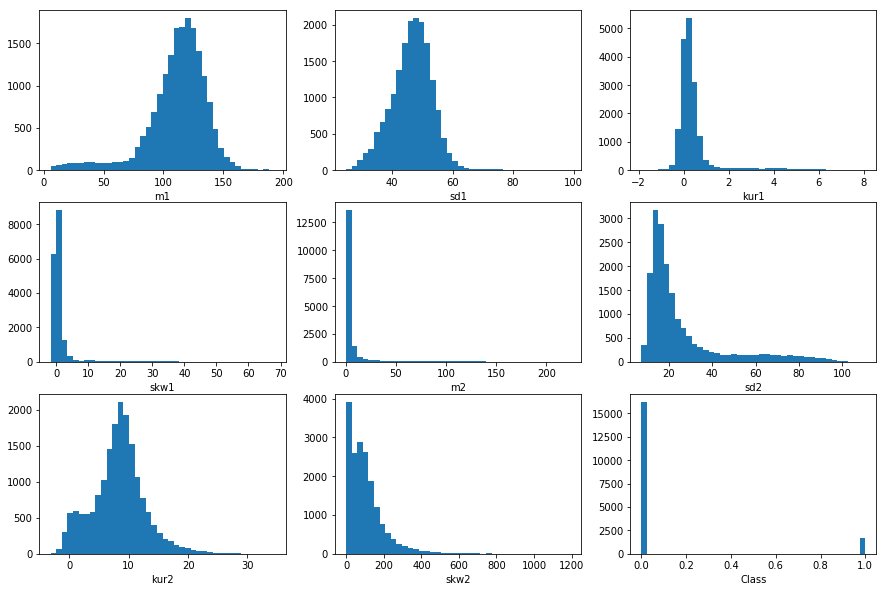

In [10]:
fig = plt.figure(figsize=(15,10))
for k in range(0,9):
    fig.add_subplot(3,3,k+1)
    plt.hist(pulsars.iloc[:,k], bins = 40);
    plt.xlabel(pulsars.columns[k]);
    

** Commentaire ** : Les histogrammes confirment les hypothèses faites sur les boxplots. Les distributions de m1, sd1 et kur1 pourraient ressembler à des distributions normales, parmis les autres variables présentes, on pourrait voir une ressemblance avec une loi exponnentielle.

MATRICE DE CORRELATION

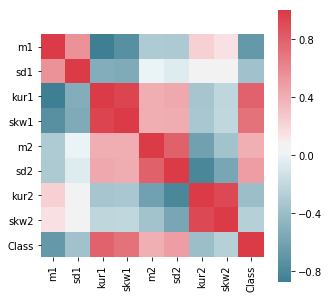

In [11]:
f, ax = plt.subplots(figsize=(5,5))
corr = pulsars.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

On peut également utiliser la commande :

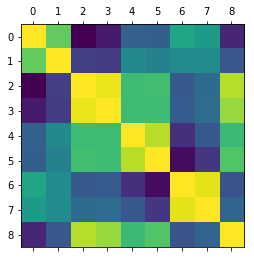

In [12]:
plt.matshow(pulsars.corr());

** Commentaire ** : On observe assez nettement une corrélation des variables par blocs de 2. Les variables m1 et kur1 sont corrélées négativement.

COMPLEMENTS

1) test de normalité de Shapiro

In [17]:
from scipy.stats import shapiro

In [18]:
for k in range(0,9):
    print(shapiro(pulsars.iloc[:,k]))

(0.9034209251403809, 0.0)
(0.9821668267250061, 5.3571640291137757e-42)
(0.5529826879501343, 0.0)
(0.3518037796020508, 0.0)
(0.42094260454177856, 0.0)
(0.7290873527526855, 0.0)
(0.9736634492874146, 0.0)
(0.7827756404876709, 0.0)
(0.3252568244934082, 0.0)


La première valeur est le résultat de la statistique de test, la seconde est la p-value. Si p-value < seuil = 0.05, on rejette l'hypothèse de normalité. Ici, l'hypothèse de normalité est toujours rejettée.

On propose ci-dessous 2 exemples sur des valeurs simulées pour mieux appréhender le fonctionnement de la fonction shapiro.

In [19]:
U = np.random.normal(0, 1, 50)
shapiro(U)

(0.9916431307792664, 0.9767956137657166)

In [20]:
V = np.random.uniform(-1,1,50)
shapiro(V)


(0.9485776424407959, 0.029829325154423714)

2) tests d'indépendance

In [21]:
from scipy.stats import spearmanr

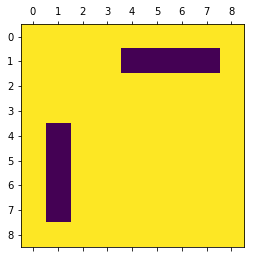

In [22]:
plt.matshow(spearmanr(pulsars).pvalue<0.05);

Avec le test d'indépendance non paramétrique de Spearman (utilisé lorsque les variables ne sont pas gaussiennes), on observe que les variables sont liées entre elles à l'exception de la variable sd1 qui est indépendante du groupe de variable avec indice 2. 

<img src="http://media.giphy.com/media/ASd0Ukj0y3qMM/giphy.gif" width = 300>
<a id="2"></a> 
 
# 2. SVM

In [23]:
from sklearn import svm
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


((1789, 8), (1789L,))
((16109, 8), (16109L,))


On sépare l'ensemble de données en un ensemble de "test" et un ensemble d'apprentissage "train"

In [26]:
X_train, X_test, y_train, y_test = train_test_split(pulsars.iloc[:,0:8], pulsars.iloc[:,8], test_size=0.9, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((1789, 8), (1789L,))
((16109, 8), (16109L,))


In [28]:
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='sigmoid', gamma=0.7, C=C))
models = (clf.fit(X_train, y_train) for clf in models)

methods = ("SVM linear kernel",
          "SVM RBF kernel",
          "SVM sigmoid kernel")

SCORES. Pourcentages de réponses correctement prédites

In [29]:
u = []
for clf in models:
    u = u + [(clf.predict(X_test)==y_test).sum()/(1.0*y_test.shape[0])]
    print(methods[len(u)-1]+" : "+str(u[-1]))

SVM linear kernel : 0.9792662486808617
SVM RBF kernel : 0.9089328946551617
SVM sigmoid kernel : 0.9089328946551617


In [30]:
print("le meilleur modèle est ici : "+str(methods[np.argmax(u)]))

le meilleur modèle est ici : SVM linear kernel


OPTIMISATION DU PARAMETRE C

In [31]:
from sklearn.model_selection import cross_val_score
import sys

In [32]:
l = []
params = np.linspace(0.1,3,30)
for c in params:
    clf = svm.SVC(kernel="linear", C = c)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    l = l + [scores.mean()]
    sys.stdout.write(".")

..............................

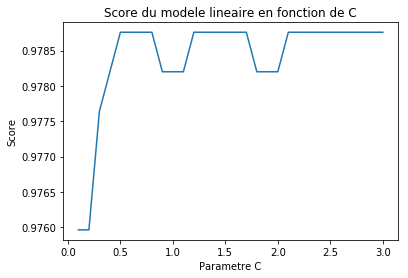

In [33]:
plt.figure()
plt.plot(params,l)
plt.title("Score du modele lineaire en fonction de C")
plt.xlabel("Parametre C")
plt.ylabel("Score")
plt.show()

In [34]:
print(np.argmax(l))
print(params[np.argmax(l)])
OptimC = params[np.argmax(l)]

4
0.5


In [35]:
svm.SVC(kernel="linear", C = OptimC).fit(X_train, y_train).score(X_test, y_test)

0.9793283257806196

In [36]:
u[0]

0.9792662486808617

La performance n'est  que très légèrement amélioré avec un C optimisé pour le SVM linéaire.

C non optimisé

In [37]:
model = svm.SVC(kernel='linear', C=1) 
model.fit(X_train, y_train)
(model.predict(X_test) == y_test).sum()

15775

C optimisé

In [38]:
model = svm.SVC(kernel='linear', C=OptimC) 
model.fit(X_train, y_train)
(model.predict(X_test) == y_test).sum()

15776

ETUDE AVEC LE SCORE MODIFIE

In [138]:
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='sigmoid', gamma=0.7, C=C))
models = (clf.fit(X_train, y_train) for clf in models)

In [139]:
v = []
for clf in models:
    v = v + [(clf.predict(X_test[y_test==1]) == 1).sum()/(y_test.sum()*1.0)]
    print(methods[len(v)-1]+" : "+str(v[-1]))

SVM linear kernel : 0.814587593728698
SVM RBF kernel : 0.0
SVM sigmoid kernel : 0.0


On voit que les SVM avec kernel RBF et sigmoid ne capture pas correctement la classe 1

OPTIMISATION DU PARAMETRE C

In [140]:
def new_score(clf,X_test,y_test):
    return (clf.predict(X_test[y_test==1])==1).sum()/(y_test.sum()*1.0)

vecteur Z pour faire la cross validation:

In [177]:
Z = np.random.randint(1, 4, len(y_train))

In [184]:
params = np.linspace(0.1,3,30)
m = []
for c in params:
    l = []
    clf = svm.SVC(kernel="linear", C = c)
    for d in range(1,4):
        clf.fit(X_train.iloc[Z == d,:], y_train[Z == d])
        l = l + [new_score(clf,X_train.iloc[Z != d,:],y_train[Z != d])]
    m = m + [np.mean(l)]
    sys.stdout.write(".")

..............................

In [185]:
print(np.argmax(m))
print(params[np.argmax(m)])
OptimC2 = params[np.argmax(m)]

20
2.0999999999999996


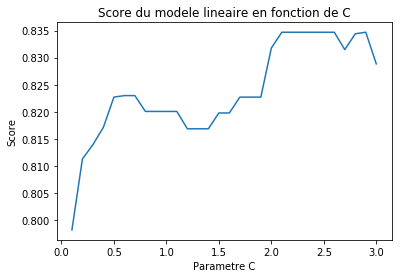

In [186]:
plt.figure()
plt.plot(params,m)
plt.title("Score du modele lineaire en fonction de C")
plt.xlabel("Parametre C")
plt.ylabel("Score")
plt.show()

In [190]:
(svm.SVC(kernel="linear", C = OptimC2).fit(X_train, y_train).predict(X_test[y_test==1])==1).sum()/(y_test.sum()*1.0)

0.8193592365371506

<img src="http://media.giphy.com/media/ASd0Ukj0y3qMM/giphy.gif" width = 300>
<a id="3"></a> 
 
# 3. Naive Bayes, LDA, QDA

In [191]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
gnb = GaussianNB()
LDA = LinearDiscriminantAnalysis()
QDA = QuadraticDiscriminantAnalysis()

In [192]:
score_gnb = gnb.fit(X_train, y_train).score(X_test, y_test)
score_gnb

0.9417716804270905

In [193]:
score_LDA = LDA.fit(X_train, y_train).score(X_test, y_test)
score_LDA

0.9764727791917561

In [194]:
score_QDA = QDA.fit(X_train, y_train).score(X_test, y_test)
score_QDA

0.9692718356198399

In [199]:
res_gnb2 = gnb.fit(X_train, y_train).predict(X_test[y_test==1])
(res_gnb2 == 1).sum()/(y_test.sum()*1.0)


0.8561690524880708

In [200]:
res_LDA2 = LDA.fit(X_train, y_train).predict(X_test[y_test==1])
(res_LDA2 == 1).sum()/(y_test.sum()*1.0)

0.7825494205862304

In [201]:
res_QDA2 = QDA.fit(X_train, y_train).predict(X_test[y_test==1])
(res_QDA2 == 1).sum()/(y_test.sum()*1.0)

0.8643490115882754

LDA est le meilleur avec le score standard. QDA est le meilleur avec notre score

<img src="http://media.giphy.com/media/ASd0Ukj0y3qMM/giphy.gif" width = 300>
<a id="4"></a> 
 
# 4. k-NN

In [202]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

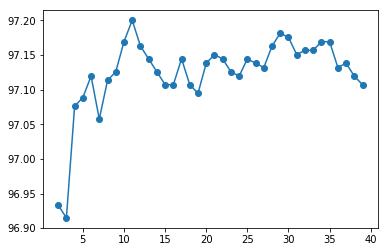

In [203]:
errors2 = []

for k in range(2,40):
    knn = neighbors.KNeighborsClassifier(k)
    errors2.append(100*(knn.fit(X_train, y_train).score(X_test, y_test)))

plt.plot(range(2,40), errors2, 'o-')
plt.show()


In [204]:
np.argmax(errors2)

9

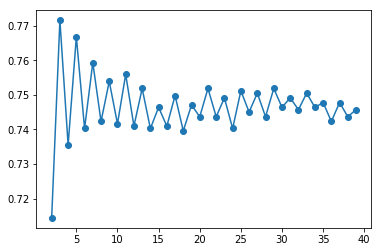

In [205]:
errors2 = []

for k in range(2,40):
    knn = neighbors.KNeighborsClassifier(k)
    res = knn.fit(X_train, y_train).predict(X_test[y_test==1])
    errors2 = errors2 +[(res == 1).sum()/(y_test.sum()*1.0)]
plt.plot(range(2,40), errors2, 'o-')
plt.show()

In [206]:
errors2[np.argmax(errors2)]

0.7716428084526245

<img src="http://media.giphy.com/media/ASd0Ukj0y3qMM/giphy.gif" width = 300>
<a id="5"></a> 
 
# 5. Régression logistique

In [207]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
res=logit.fit(X_train, y_train)
# Erreur
res.score(X_test, y_test)

0.9779005524861878

In [208]:
logit = res.predict(X_test[y_test==1])

In [209]:
(logit == 1).sum()/(y_test.sum()*1.0)

0.809134287661895

CONCLUSION : 

Aucune des méthodes étudiées ne donnent un score > 90 % avec notre score. On a toujours plus de 10% de faux négatifs :

logistique : 0.809134287661895

knn : 0.7716428084526245

gnb : 0.8561690524880708

LDA : 0.7825494205862304

QDA : 0.8643490115882754